In [4]:
# Pkg.add("LowRankModels")
# Pkg.update()
# Pkg.add("SCS")

In [5]:
# Pkg.add("Gadfly")
using Convex
using DataFrames
using PyPlot
using SCS

In [6]:
include("proxgrad.jl")

proxgrad_const (generic function with 1 method)

In [7]:
# load data
listings = readtable("listings_cleaned_smaller.csv")

,host_since,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,latitude,longitude,is_location_exact,accommodates,bathrooms,bedrooms,beds,amenities,square_feet,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,property_type_apartment,property_type_bed_breakfast,property_type_boat,property_type_bungalow,property_type_cabin,property_type_camper_rv,property_type_castle,property_type_cave,property_type_chalet,property_type_condominium,property_type_dorm,property_type_earth_house,property_type_entire_floor,property_type_guesthouse,property_type_house,property_type_hut,property_type_lighthouse,property_type_loft,property_type_other,property_type_parking_space,property_type_plane,property_type_tent,property_type_tipi,property_type_townhouse,property_type_train,property_type_treehouse,property_type_villa,property_type_yurt,room_type_entire_home_apt,room_type_private_room,room_type_shared_room,bed_type_airbed,bed_type_couch,bed_type_futon,bed_type_pull_out_sofa,bed_type_real_bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_no_refunds,cancellation_policy_strict,cancellation_policy_super_strict_60
1,49,0.0,0.0,0,1,6,1,1,34.04206443,-118.2532204,1,3,1.0,1,1,18,0,180,0,15,1,0,2,2,0,0,0,0,2,100,10,10,10,10,10,10,0,0.12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0
2,35,1.0,1.0,1,1,4,1,1,34.09483054,-118.2644041,1,3,1.0,2,2,10,0,225,0,80,1,0,3,1125,0,0,15,283,38,99,10,9,10,10,10,10,0,1.27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
3,52,0.87,0.93,0,1,4,1,1,34.11247523,-118.3364378,1,2,1.0,1,1,12,0,102,0,20,2,20,1,5,22,52,80,355,41,94,10,9,10,10,10,9,0,1.2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0
4,29,1.0,1.0,0,1,6,1,1,34.06455122,-118.4951368,0,3,1.0,1,2,14,0,330,0,0,1,0,1,1125,29,59,89,364,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0
5,31,0.75,1.0,0,1,3,1,0,33.98847795,-118.4411853,1,2,1.0,1,1,23,0,125,0,0,1,0,1,1125,30,60,90,365,0,0,0,0,0,0,0,0,0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0
6,8,0.0,0.0,0,1,5,1,1,34.08636554,-118.3107836,1,2,1.0,1,1,17,0,50,0,0,1,0,1,1125,0,0,0,214,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0
7,6,0.0,1.0,0,1,1,1,0,33.92738545,-118.2697351,1,2,2.0,1,2,13,0,50,100,20,1,0,5,1125,28,58,88,88,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0
8,3,0.0,0.0,0,1,2,1,0,34.06783664,-118.3492394,1,2,1.5,1,1,17,0,350,0,0,1,0,1,1125,29,29,29,29,0,0,0,0,0,0,0,0,0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0
9,26,0.0,0.0,0,1,5,1,1,34.04959846,-118.4633752,1,1,1.0,1,1,17,0,100,445,0,1,0,1,1125,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0
10,17,1.0,0.9,0,1,6,1,1,34.08844529,-118.3551676,1,3,1.0,1,1,17,0,65,0,0,1,15,1,1125,1,3,33,308,21,88,9,9,9,9,9,9,0,1.74,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0


In [8]:
# fit a linear model
x = copy(listings)
x[:offset] = 1
# delete!(x, :price)
x

,host_since,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,latitude,longitude,is_location_exact,accommodates,bathrooms,bedrooms,beds,amenities,square_feet,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,property_type_apartment,property_type_bed_breakfast,property_type_boat,property_type_bungalow,property_type_cabin,property_type_camper_rv,property_type_castle,property_type_cave,property_type_chalet,property_type_condominium,property_type_dorm,property_type_earth_house,property_type_entire_floor,property_type_guesthouse,property_type_house,property_type_hut,property_type_lighthouse,property_type_loft,property_type_other,property_type_parking_space,property_type_plane,property_type_tent,property_type_tipi,property_type_townhouse,property_type_train,property_type_treehouse,property_type_villa,property_type_yurt,room_type_entire_home_apt,room_type_private_room,room_type_shared_room,bed_type_airbed,bed_type_couch,bed_type_futon,bed_type_pull_out_sofa,bed_type_real_bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_no_refunds,cancellation_policy_strict,cancellation_policy_super_strict_60,offset
1,49,0.0,0.0,0,1,6,1,1,34.04206443,-118.2532204,1,3,1.0,1,1,18,0,180,0,15,1,0,2,2,0,0,0,0,2,100,10,10,10,10,10,10,0,0.12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1
2,35,1.0,1.0,1,1,4,1,1,34.09483054,-118.2644041,1,3,1.0,2,2,10,0,225,0,80,1,0,3,1125,0,0,15,283,38,99,10,9,10,10,10,10,0,1.27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1
3,52,0.87,0.93,0,1,4,1,1,34.11247523,-118.3364378,1,2,1.0,1,1,12,0,102,0,20,2,20,1,5,22,52,80,355,41,94,10,9,10,10,10,9,0,1.2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1
4,29,1.0,1.0,0,1,6,1,1,34.06455122,-118.4951368,0,3,1.0,1,2,14,0,330,0,0,1,0,1,1125,29,59,89,364,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1
5,31,0.75,1.0,0,1,3,1,0,33.98847795,-118.4411853,1,2,1.0,1,1,23,0,125,0,0,1,0,1,1125,30,60,90,365,0,0,0,0,0,0,0,0,0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1
6,8,0.0,0.0,0,1,5,1,1,34.08636554,-118.3107836,1,2,1.0,1,1,17,0,50,0,0,1,0,1,1125,0,0,0,214,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1
7,6,0.0,1.0,0,1,1,1,0,33.92738545,-118.2697351,1,2,2.0,1,2,13,0,50,100,20,1,0,5,1125,28,58,88,88,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1
8,3,0.0,0.0,0,1,2,1,0,34.06783664,-118.3492394,1,2,1.5,1,1,17,0,350,0,0,1,0,1,1125,29,29,29,29,0,0,0,0,0,0,0,0,0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1
9,26,0.0,0.0,0,1,5,1,1,34.04959846,-118.4633752,1,1,1.0,1,1,17,0,100,445,0,1,0,1,1125,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1
10,17,1.0,0.9,0,1,6,1,1,34.08844529,-118.3551676,1,3,1.0,1,1,17,0,65,0,0,1,15,1,1125,1,3,33,308,21,88,9,9,9,9,9,9,0,1.74,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1


In [9]:
# smalldata = x[1:10, [:accommodates, :bathrooms, :beds, :amenities, :number_of_reviews, :review_scores_rating]]
n = 10
x1 = convert(Array{Float64}, x[1:n, [:accommodates, :beds, :amenities, :review_scores_rating, :offset]])
x2 = convert(Array{Float64}, x[1:n, [:accommodates, :beds, :offset]])
x3 = convert(Array{Float64}, x[1:n, [:accommodates, :beds, :room_type_entire_home_apt, :offset]])
x4 = convert(Array{Float64}, x[1:n, [:accommodates, :beds, :room_type_entire_home_apt, :reviews_per_month, :offset]])
x5 = convert(Array{Float64}, x[1:n, [:accommodates, :beds, :bed_type_real_bed, :room_type_entire_home_apt, :reviews_per_month, :property_type_apartment, :offset]])

y = convert(Array{Float64}, x[1:n, [:price]])
y = y[:,1]

10-element Array{Float64,1}:
 180.0
 225.0
 102.0
 330.0
 125.0
  50.0
  50.0
 350.0
 100.0
  65.0

In [55]:
function lasso(X,y; λ=1)
    @show d = size(X,2)
    @show w = Variable(d)
    @show p = minimize(sumsquares(X*w - y) + λ*norm(w,1))
    solve!(p)
    return w.value
end

function ridge_regression(X,y; λ=1)
    d = size(X,2)
    w = Variable(d)
    p = minimize(sumsquares(X*w - y) + λ*sumsquares(w))
    solve!(p)
    return w.value
end

function nnls(X,y)
    d = size(X,2)
    w = Variable(d)
    p = minimize(sumsquares(X*w - y), w>=0)
    solve!(p)
    return w.value
end

function ols(x, y)
    return x\y
end

function RMSE(w, x, y)
    n = length(y)
    f(x_i) = vecdot(w,x_i)
    total_error = 0
    for i = 1:size(x,1)
        actual = y[i]
        predicted = f(x[i,:])
        total_error += (actual - predicted)^2
    end
    return sqrt(total_error / n)
end

function squared_error(w, x, y)
    f(x_i) = vecdot(w,x_i)
    total_error = 0
    for i = 1:size(x,1)
        actual = y[i]
        predicted = f(x[i,:])
        total_error += (actual - predicted)^2
    end
    return total_error
end

function abs_error(w, x, y)
    f(x_i) = vecdot(w,x_i)
    total_error = 0
    for i = 1:size(x,1)
        actual = y[i]
        predicted = f(x[i,:])
        total_error += abs(actual - predicted)
    end
    return total_error
end

abs_error (generic function with 1 method)

In [47]:
n = length(y)

# huber regression
w_huber1 = proxgrad(1/n*HuberLoss(), ZeroReg(), x1, y, maxiters=200)
w_huber2 = proxgrad(1/n*HuberLoss(), ZeroReg(), x2, y, maxiters=200)
w_huber3 = proxgrad(1/n*HuberLoss(), ZeroReg(), x3, y, maxiters=200)
w_huber4 = proxgrad(1/n*HuberLoss(), ZeroReg(), x4, y, maxiters=200)
w_huber5 = proxgrad(1/n*HuberLoss(), ZeroReg(), x5, y, maxiters=200)

@show err_huber1 = RMSE(w_huber1, x1, y)
@show err_huber2 = RMSE(w_huber2, x2, y)
@show err_huber3 = RMSE(w_huber3, x3, y)
@show err_huber4 = RMSE(w_huber4, x4, y)
@show err_huber5 = RMSE(w_huber5, x5, y)

# ordinary least squares regression
lambda = 1
w_quad1 = proxgrad(1/n*QuadLoss(), ZeroReg(), x1, y, maxiters=200)
w_quad2 = proxgrad(1/n*QuadLoss(), ZeroReg(), x2, y, maxiters=200)
w_quad3 = proxgrad(1/n*QuadLoss(), ZeroReg(), x3, y, maxiters=200)
w_quad4 = proxgrad(1/n*QuadLoss(), ZeroReg(), x4, y, maxiters=200)
w_quad5 = proxgrad(1/n*QuadLoss(), ZeroReg(), x5, y, maxiters=200)
w_quad5_l1 = proxgrad(1/n*QuadLoss(), OneReg(lambda), x5, y, maxiters=200)
w_quad5_l2 = proxgrad(1/n*QuadLoss(), QuadReg(lambda), x5, y, maxiters=200)

@show err_quad1 = RMSE(w_quad1, x1, y)
@show err_quad2 = RMSE(w_quad2, x2, y)
@show err_quad3 = RMSE(w_quad3, x3, y)
@show err_quad4 = RMSE(w_quad4, x4, y)
@show err_quad5 = RMSE(w_quad5, x5, y)
@show err_quad5_l1 = RMSE(w_quad5_l1, x5, y)
@show err_quad5_l2 = RMSE(w_quad5_l2, x5, y)

# l1 loss regression
w_l1_1 = proxgrad(1/n*L1Loss(), ZeroReg(), x1, y, maxiters=200)
w_l1_2 = proxgrad(1/n*L1Loss(), ZeroReg(), x2, y, maxiters=200)
w_l1_3 = proxgrad(1/n*L1Loss(), ZeroReg(), x3, y, maxiters=200)
w_l1_4 = proxgrad(1/n*L1Loss(), ZeroReg(), x4, y, maxiters=200)
w_l1_5 = proxgrad(1/n*L1Loss(), ZeroReg(), x5, y, maxiters=200)

@show err_l1_1 = RMSE(w_l1_1, x1, y)
@show err_l1_2 = RMSE(w_l1_2, x2, y)
@show err_l1_3 = RMSE(w_l1_3, x3, y)
@show err_l1_4 = RMSE(w_l1_4, x4, y)
@show err_l1_5 = RMSE(w_l1_5, x5, y)

# quantile regression
w_quantile5 = proxgrad(1/n*QuantileLoss(quantile=.4), ZeroReg(), x5, y, maxiters=1000)
@show err_quantile5 = RMSE(w_quantile5, x5, y)

err_huber1 = RMSE(w_huber1,x1,y) = 127.18131022402821
err_huber2 = RMSE(w_huber2,x2,y) = 97.83444280971432
err_huber3 = RMSE(w_huber3,x3,y) = 93.94421934440548
err_huber4 = RMSE(w_huber4,x4,y) = 89.71285463767255
err_huber5 = RMSE(w_huber5,x5,y) = 90.733769244861
err_quad1 = RMSE(w_quad1,x1,y) = 111.07995369591605
err_quad2 = RMSE(w_quad2,x2,y) = 97.79871000381652
err_quad3 = RMSE(w_quad3,x3,y) = 87.96960517705075
err_quad4 = RMSE(w_quad4,x4,y) = 75.4927500056053
err_quad5 = RMSE(w_quad5,x5,y) = 68.33196636994485
err_quad5_l1 = RMSE(w_quad5_l1,x5,y) = 68.98426155694935
err_quad5_l2 = RMSE(w_quad5_l2,x5,y) = 92.44892611136116
err_l1_1 = RMSE(w_l1_1,x1,y) = 132.8136356759719
err_l1_2 = RMSE(w_l1_2,x2,y) = 97.97000816576468
err_l1_3 = RMSE(w_l1_3,x3,y) = 95.91229717820336
err_l1_4 = RMSE(w_l1_4,x4,y) = 95.7354663913244
err_l1_5 = RMSE(w_l1_5,x5,y) = 94.61478489358885
err_quantile5 = RMSE(w_quantile5,x5,y) = 91.8137872596248


91.8137872596248

In [48]:
# ordinary least squares

w_ols1 = ols(x1, y)
w_ols2 = ols(x2, y)
w_ols3 = ols(x3, y)
w_ols4 = ols(x4, y)
w_ols5 = ols(x5, y)

@show err_ols1 = RMSE(w_ols1, x1, y)
@show err_ols2 = RMSE(w_ols2, x2, y)
@show err_ols3 = RMSE(w_ols3, x3, y)
@show err_ols4 = RMSE(w_ols4, x4, y)
@show err_ols5 = RMSE(w_ols5, x5, y)


err_ols1 = RMSE(w_ols1,x1,y) = 88.82214816773387
err_ols2 = RMSE(w_ols2,x2,y) = 97.79274830794776
err_ols3 = RMSE(w_ols3,x3,y) = 87.94513727211597
err_ols4 = RMSE(w_ols4,x4,y) = 75.34039360296029
err_ols5 = RMSE(w_ols5,x5,y) = 67.17540733722622


67.17540733722622

In [49]:
w_ridge1 = ridge_regression(x1, y)
@show err_ridge1 = RMSE(w_ridge1, x1, y)


----------------------------------------------------------------------------
	SCS v1.1.8 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2015
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 60
eps = 1.00e-04, alpha = 1.80, max_iters = 20000, normalize = 1, scale = 5.00
Variables n = 10, constraints m = 26
Cones:	primal zero / dual free vars: 1
	linear vars: 2
	soc vars: 23, soc blks: 4
Setup time: 7.78e-05s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0|      inf       inf      -nan      -inf       inf       inf  2.93e-05 
   100|      inf       inf      -nan       inf       inf       inf  1.49e-04 
   200|      inf       inf      -nan       inf       inf       inf  2.66e-04 
   300|      inf       inf      

err_ridge1 = RMSE(w_ridge1,x1,y) = 91.19446675334588
03e+05  0.00e+00  2.40e-02 
----------------------------------------------------------------------------
Status: Solved/Inaccurate
Hit max_iters, solution may be inaccurate
Timing: Solve time: 2.40e-02s
	Lin-sys: nnz in L factor: 114, avg solve time: 5.07e-07s
	Cones: avg projection time: 1.85e-07s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 4.9852e-11, dist(y, K*) = 9.0949e-13, s'y/m = 7.1507e-08
|Ax + s - b|_2 / (1 + |b|_2) = 9.1600e-03
|A'y + c|_2 / (1 + |c|_2) = 3.2812e-01
|c'x + b'y| / (1 + |c'x| + |b'y|) = 1.1341e-06
----------------------------------------------------------------------------
c'x = 103163.4371, -b'y = 103163.2031


91.19446675334588

In [50]:
w_lasso1 = lasso(x1, y)
@show err_lasso1 = RMSE(w_lasso1, x1, y)


d = size(X,2) = 5
w = Variable(d) = Variable of
size: (5, 1)
sign: Convex.NoSign()
vexity: Convex.AffineVexity()
p = minimize(sumsquares(X * w - y) + λ * norm(w,1)) = Problem:
minimize AbstractExpr with
head: +
size: (1, 1)
sign: Convex.Positive()
vexity: Convex.ConvexVexity()

subject to

current status: not yet solved
----------------------------------------------------------------------------
	SCS v1.1.8 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2015
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 75
eps = 1.00e-04, alpha = 1.80, max_iters = 20000, normalize = 1, scale = 5.00
Variables n = 13, constraints m = 26
Cones:	primal zero / dual free vars: 1
	linear vars: 11
	soc vars: 14, soc blks: 2
Setup time: 6.61e-05s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
--------------------

88.90691231150379

In [51]:
# w_nonneg1 = nnls(x1, y)
# @show err_nonneg1 = test(w_nonneg1, x1, y)


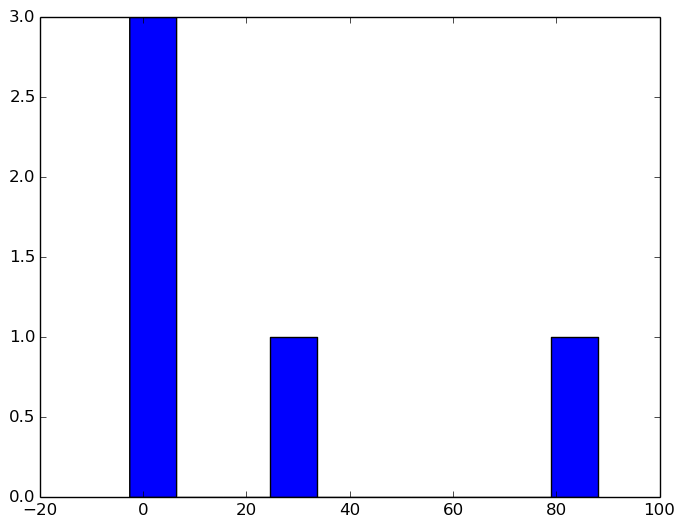

([3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0],[-2.5876,6.47827,15.5441,24.61,33.6759,42.7418,51.8076,60.8735,69.9394,79.0052,88.0711],Any[PyObject <matplotlib.patches.Rectangle object at 0x7f4b3a894e50>,PyObject <matplotlib.patches.Rectangle object at 0x7f4b3a8a44d0>,PyObject <matplotlib.patches.Rectangle object at 0x7f4b3a8a49d0>,PyObject <matplotlib.patches.Rectangle object at 0x7f4b3a8a4ed0>,PyObject <matplotlib.patches.Rectangle object at 0x7f4b3a8b0590>,PyObject <matplotlib.patches.Rectangle object at 0x7f4b3a8b0a90>,PyObject <matplotlib.patches.Rectangle object at 0x7f4b3a8b0f90>,PyObject <matplotlib.patches.Rectangle object at 0x7f4b3a8bc4d0>,PyObject <matplotlib.patches.Rectangle object at 0x7f4b3a8bc9d0>,PyObject <matplotlib.patches.Rectangle object at 0x7f4b3a8bced0>])

In [52]:
plt[:hist](w_ridge1)

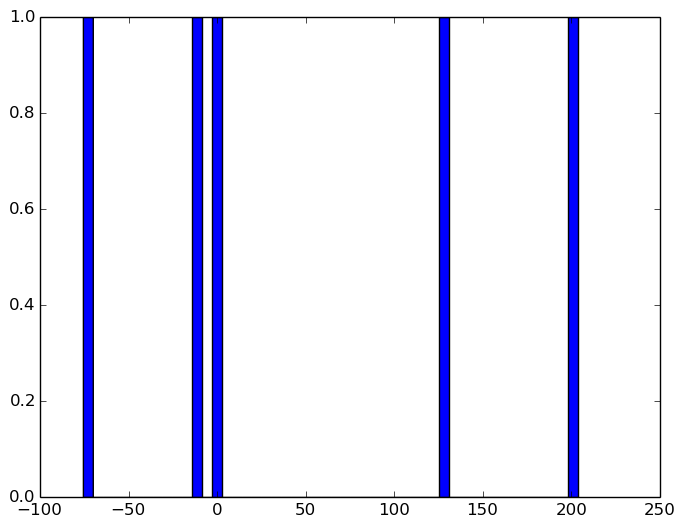

([1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0],[-75.5006,-69.9197,-64.3388,-58.7579,-53.1769,-47.596,-42.0151,-36.4341,-30.8532,-25.2723  …  153.317,158.898,164.479,170.06,175.641,181.222,186.803,192.384,197.965,203.546],Any[PyObject <matplotlib.patches.Rectangle object at 0x7f4b3a77e890>,PyObject <matplotlib.patches.Rectangle object at 0x7f4b3a77eed0>,PyObject <matplotlib.patches.Rectangle object at 0x7f4b3a78d410>,PyObject <matplotlib.patches.Rectangle object at 0x7f4b3a78d910>,PyObject <matplotlib.patches.Rectangle object at 0x7f4b3a78de10>,PyObject <matplotlib.patches.Rectangle object at 0x7f4b3a799350>,PyObject <matplotlib.patches.Rectangle object at 0x7f4b3a799850>,PyObject <matplotlib.patches.Rectangle object at 0x7f4b3a799d50>,PyObject <matplotlib.patches.Rectangle object at 0x7f4b3a7a6290>,PyObject <matplotlib.patches.Rectangle object at 0x7f4b3a7a6790>  …  PyObject <matplotlib.patches.Rectangle object at 0x7f4b3a723990>,PyObject <matplo

In [53]:
plt[:hist](w_lasso1, bins=50)